## Questão 2: Perceptron Backpropagation 

## Problema

Implemente uma rede perceptron de múltiplas camadas treinando-a com os seguinte algoritmos
    
  __a)__ algoritmo da retropropagação em modo estocástico usando a regra delta
    
  __b)__ algoritmo da retropropagação em modo por lote usando a regra delta
   
  __c)__ algoritmo da retropropagação usando a regra delta com termo do momento

In [126]:
import statistics as st
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from misc import plots

## Funções de Ativação

Foram implementadas funções básicas de ativação para serem opções no uso na rede.

In [113]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0.1, 1)
    return np.where(x < 0, 0.1*x, x)

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

def degrau(x, derivative=False):
    if derivative:
        np.where(x>0.5,1,1)
    return np.where(x>0.5,1,0)

def step(x,derivative=False):
    if derivative:
        return np.where(x>0,1,1)
    return np.where(x>0,1,0)

## Função de Custo

In [114]:
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return np.mean((y - y_pred)**2)

In [115]:
def sigmoid_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

In [116]:
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

## Função Suporte

In [117]:
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

In [118]:
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

In [119]:
same = lambda x: x
# tupla(x,limit)
threshold = lambda x: np.where(x[0]>x[1], 1, 0)

## Plotagem dos erros

In [142]:
def plot_error(data=[], label=['', ''], color=['blue', 'red']):
    plt.title("Erros de treino e validação")
    plt.xlabel("epochs")
    plt.ylabel("errors")
    plt.legend(handles=[mpatches.Patch(color=color[0], label=label[0]),
                        mpatches.Patch(color=color[1], label=label[1])])
    plt.plot(data[0], c=color[0])
    plt.plot(data[1], c=color[1])
    plt.show()


def plot_q5(x, y, y_pred):
    dataX = x

    datas = {'real': [], 'n+1': [], 'n+2': [], 'n+3': []}
    colors = ['red', 'blue', 'green', 'pink']

    labels = ['real', 'n+1', 'n+2', 'n+3']
    patches = []

    for index in range(k, len(y) - n):
        datas['real'].append(y[index])

    for j in range(1, 4):
        for index in range(0, len(y_pred), j):
            for d in y[index][:j-1]:
                datas['n+' + str(j)].append(d)
            datas['n+' + str(j)].append(y_pred[index][j])

    for index, label in enumerate(labels):
        patches.append(mpatches.Patch(color=colors[index], label=label))

    plt.legend(handles=patches)

    for index, label in enumerate(datas):
        plt.plot(dataX, datas[label][:len(dataX)], c=colors[index])

    #plt.plot(dataX, data[1], c=color[1])
    plt.show()

## Classe Layer

A classe Layer representa uma layer da rede guardando a entrada da camada, pesos, biases, função de ativação e saída da camada.

### Parâmetros

- __input_dim__: dimensão dos dados de entrada da camada
- ___units___: quantidade de neurônios da camada
- __activation__: função de ativação que será utilizada nos neurônios da rede

### Atributos

- __input__: dados de entrada da camada
- __weights__: matriz todos os pesos de todos os neutônios da camada
- __biases__: vetor com os valores dos bias de todos os neurônios da camada
- __activation__: função de ativação que será utilizada nos neurônios da rede
- __activ_out__: guarda os valores resultantes da função de ativação



In [121]:
class Layer:
    def __init__(self, input_dim, output_dim, activation=step, use_bias=True):
        self.input = None
        self.weights = np.random.randn(output_dim, input_dim)
        self.bias = np.random.randn(1, output_dim)
        self.activation = activation
        self._activ_inp, self._activ_out = None, None
        self.input_dim = input_dim
        self.use_bias = use_bias
        self.dweights, self.dbias = None, None
        self._dweights, self._dbias, self._prev_dweights = None, None, 0.0

## Classe NeuralNetwork

A classe representa a Rede Neural, na caso o Perceptron.

### Atributos

- __layers__: conjunto de layers da rede


In [122]:
class NeuralNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3, momentum=0.0):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = learning_rate
        self.momentum = momentum

    def fit(self,
            X,
            Y,
            X_valid=None,
            Y_valid=None,
            epochs=1,
            batch_size=None,
            verbose=False,
            accuracy=True,
            one_hot=False):
        '''
            Função de treinamento
            Parâmetros:
                X - entradas
                Y - saídas esperadas
                epochs - quantidade de épocas de treinamento
                verbose - passos para verificação da época
        '''
        batch_size = X.shape[0] if batch_size is None else batch_size
        n_batches = X.shape[0] // batch_size
        error_track = []
        error_epoch = []
        error_valid_track = []
        
        for epoch in range(epochs+1):
            errors_batch = []
            for batch in range(n_batches):
                offset = batch_size * batch
                X_batch, Y_batch = X[offset:offset + batch_size], Y[offset:offset + batch_size]
                y_pred = self.__feedforward(X_batch)
                self.__backpropagation(Y_batch, y_pred)
                
                if one_hot:
                    Y_batch = np.argmax(Y_batch, axis=1)
                    y_pred = np.argmax(y_pred, axis=1)
                    
                errors_batch.append(np.mean(np.abs(Y_batch - y_pred)))
            
            error_track.append(np.mean(errors_batch))
            
            if accuracy:
                if one_hot:
                    y_pred = self.predict(X_valid).argmax(axis=1)
                    error_valid_track.append(1 - accuracy_score(Y_valid, y_pred))
                else:
                    error_valid_track.append(1 - accuracy_score(Y_valid.astype('float'), self.predict(X_valid).astype('float'))) 
            
            if epoch % verbose == 0:
                print('Epoch: {0}/{1} \nError: {2:0.4f}%'.format(epoch, epochs, error_track[-1] * 100))
                
        return error_track, error_valid_track
    
    def add_layer(self, layer):
        '''
            Método para adição de layers ao modelo
            Parâmetros:
                layer - Layer a se adicionada ao modelo
        '''
        self.layers.append(layer)
    
    def __feedforward(self, x):
        '''
            Método de Feedforward - Efetua a multiplicação das entradas pelos pesos, soma ao bias, aplica função de ativação
            Parâmetros:
                x - dados de entrada
        '''
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0,0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.bias
            current_layer._activ_inp = y
            current_layer._activ_out = next_layer.input = current_layer.activation(y)
        return self.layers[-1]._activ_out
    
    def predict(self, X, verbose=False):
        '''
            Método de Predição - Gera um conjunto de valores resultante do processo de FeedForward nos para os dados de entrada
            Parâmetros:
                x - dados de entrada
        '''
        return self.__feedforward(X)
    
    def evaluate(self, y_pred, y, func=same, dtype=int):
        '''
            Método Evaluate - Verifica a accuracy da rede
            Parâmetros:
                y_pred - resultado do processo de FeedForward sobre os dados de entrada
                dtype - tipo dos dados
        '''
        score = 0
        total = 100.0/y.shape[0]
        y_pred = y_pred.astype(dtype)
        y = y.astype(dtype)

        for y_i, y_pred_i in zip(y,y_pred):
            y_pred_i = func(y_pred_i)
            if np.array_equal(y_i,y_pred_i):
                score+=1
        return score*total

    def __backpropagation(self, y, y_pred):
        '''
            Método para a aplicação do backpropagation
            Parâmetros:
                y - dados de saída esperados
                y_pred - resultado do processo de FeedForward sobre os dados de entrada
        '''
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True)*last_delta
            last_delta = np.dot(dactivation, layer.weights)
            layer.dweights = np.dot(dactivation.T, layer.input)
            layer.dbias = 1.0*dactivation.sum(axis=0, keepdims=True)

        for layer in reversed(self.layers):
            layer._prev_dweights = -self.learning_rate*layer.dweights + self.momentum*layer._prev_dweights
            layer.weights = layer.weights + layer._prev_dweights
            layer.biases = layer.bias - self.learning_rate*layer.dbias

## Execução

__1__ - A rede é inicializada

__2__ - Os dados de entrada e saida são obtidos

__3__ - Treinamento é feito com 80% dos dados e o Teste com os 20% restantes

__4__ - Accuracy da rede é verificada

In [112]:
# Leitura dos dados de treinamento e validação

x = []
y = []

# leitura dos dados
for line in open('data/Q2/data_x_2.txt', 'r').readlines():
    x.append([float(num) for num in line.split(',')])

for line in open('data/Q2/data_y_2.txt', 'r').readlines():
    y.append([float(num) for num in line.split(',')])

# dados de treino
x = np.array(x[:int(len(x) * 0.8)])
y = np.array(y[:int(len(y) * 0.8)])

# dados de validação
x_valid = np.array(x[int(len(x) * 0.8):])
y_valid = np.array(y[int(len(y) * 0.8):])

print("X [TREINO]: ", x.shape)
print("Y [TREINO]: ", y.shape)
print()
print("X [TESTE]: ", x_valid.shape)
print("Y [TESTE]: ", y_valid.shape)

X [TREINO]:  (3200, 3)
Y [TREINO]:  (3200, 8)

X [TESTE]:  (640, 3)
Y [TESTE]:  (640, 8)


## 2 a) Treinamento Estocástico

### Arquitetura

- __Parâmentros__: 
 - Learning Rate: 0.001
 - Layers: 2

- __Layer1__:
 - Dimensão de Entrada: 3
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Layer2__:
 - Dimensão de Entrada: 8
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Treinamento__:
 - Épocas: 100


Epoch: 0 
Error: 48.4258%
Epoch: 50 
Error: 0.0000%
Epoch: 100 
Error: 0.0000%
Epoch: 150 
Error: 0.0000%
Epoch: 200 
Error: 0.0000%


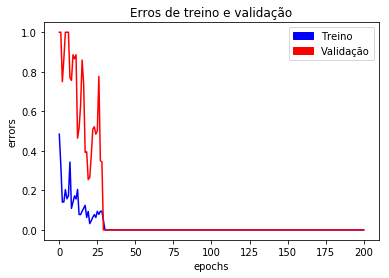

1.0


In [70]:
nn = NeuralNetwork(learning_rate=0.001)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=y.shape[1], activation=step))
nn.add_layer(Layer(input_dim=8, output_dim=8, activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid, y_valid, epochs=200, verbose=50)

plot_error([errors_train, errors_valid], ["Treino", "Validação"])

# calculo do erro de predição
y_pred = nn.prediction(x_valid)
acc = accuracy_score(y_valid, y_pred.round())

print(acc)

## 2 b) Treinamento com Batch

### Arquitetura

- __Parâmentros__: 
 - Learning Rate: 0.001
 - Layers: 2

- __Layer1__:
 - Dimensão de Entrada: 3
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Layer2__:
 - Dimensão de Entrada: 8
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Treinamento__:
 - Batch: 5
 - Épocas: 200

Epoch: 0 
Error: 28.5938%
Epoch: 50 
Error: 0.0000%
Epoch: 100 
Error: 0.0000%
Epoch: 150 
Error: 0.0000%
Epoch: 200 
Error: 0.0000%


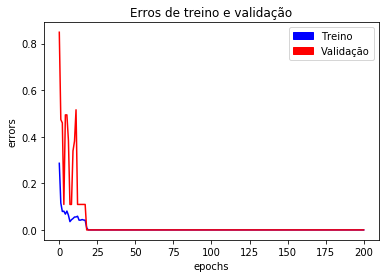

1.0


In [72]:
nn = NeuralNetwork(learning_rate=0.001)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=y.shape[1], activation=step))
nn.add_layer(Layer(input_dim=8, output_dim=8, activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid, y_valid, batch_size=5, epochs=200, verbose=50)

plot_error([errors_train, errors_valid], ["Treino", "Validação"])

# calculo do erro de predição
y_pred = nn.prediction(x_valid)
acc = accuracy_score(y_valid, y_pred.round())

print(acc)

## 2 c) Momentum

### Arquitetura

- __Parâmentros__: 
 - Learning Rate: 0.001
 - Layers: 2
 - Momentum: 0.9

- __Layer1__:
 - Dimensão de Entrada: 3
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Layer2__:
 - Dimensão de Entrada: 8
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Treinamento__:
 - Épocas: 500


Epoch: 0 
Error: 39.1172%
Epoch: 50 
Error: 7.8672%
Epoch: 100 
Error: 6.3125%
Epoch: 150 
Error: 4.7422%
Epoch: 200 
Error: 3.1055%
Epoch: 250 
Error: 6.1992%
Epoch: 300 
Error: 0.0000%
Epoch: 350 
Error: 1.6250%
Epoch: 400 
Error: 0.0000%
Epoch: 450 
Error: 0.0000%
Epoch: 500 
Error: 0.0000%


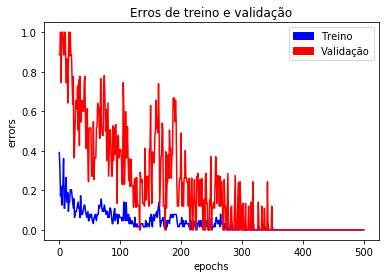

1.0


In [78]:
nn = NeuralNetwork(cost_func=mse, learning_rate=0.001, momentum=0.9)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=y.shape[1], activation=step))
nn.add_layer(Layer(input_dim=8, output_dim=8, activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid, y_valid, epochs=500, verbose=50)

plot_error([errors_train, errors_valid], ["Treino", "Validação"])

# calculo do erro de predição
y_pred = nn.prediction(x_valid)
acc = accuracy_score(y_valid, y_pred.round())

print(acc)

# Questão 3 - Convergência dos Algoritmos

## Problema

Usando algoritmos implementados na questão 2, aproxime as funções abaixo. Compare os resultados com as curvas exatas, para o caso dos itens b e c e apresente para cada caso a curva do erro médio de treinamento com relação ao número de épocas e a curva do erro médio com o conjunto de validação. Faça uma análise comparativa sobre a convergência de cada um dos algoritmos.

  __a)__ Função lógica XOR
  
  __b)__ f(x) = sen(pi*x) / pi*x
  
## 3 a)


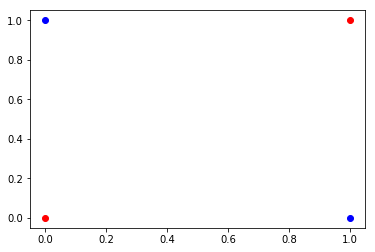

In [72]:
# Leitura dos dados de treinamento e validação

x = [[0,0], [0,1], [1,0], [1,1]]
y = [[0], [1], [1], [0]]

# leitura dos dados
# for line in open('data/Q3/data_x-3a.txt', 'r').readlines():
#     x.append([float(num) for num in line.split(',')])

# for line in open('data/Q3/data_y-3a.txt', 'r').readlines():
#     y.append([float(num) for num in line.split(',')])

# dados de treino
x = np.array(x)
y = np.array(y)

# dados de validação
x_valid = x
y_valid = y

# print("X [TREINO]: ", x.shape)
# print("Y [TREINO]: ", y.shape)
# print()
# print("X [TESTE]: ", x_valid.shape)
# print("Y [TESTE]: ", y_valid.shape)

for index, y_i in enumerate(y):
    if y_i[0] == 1:
        plt.plot(x[index][0], x[index][1], 'bo')
    else:
        plt.plot(x[index][0], x[index][1], 'ro')

plt.show()

### Estocástico

### Arquitetura

- __Parâmentros__: 
 - Learning Rate: 0.001
 - Layers: 2

- __Layer1__:
 - Dimensão de Entrada: 2
 - Dimensão de Saída: 2
 - Função de Ativação: Sigmoid

- __Layer2__:
 - Dimensão de Entrada: 2
 - Dimensão de Saída: 1
 - Função de Ativação: Step

- __Treinamento__:
 - Épocas: 600

Epoch: 0/1000 
Error: 50.0000%
Epoch: 100/1000 
Error: 50.0000%
Epoch: 200/1000 
Error: 50.0000%
Epoch: 300/1000 
Error: 25.0000%
Epoch: 400/1000 
Error: 25.0000%
Epoch: 500/1000 
Error: 25.0000%
Epoch: 600/1000 
Error: 25.0000%
Epoch: 700/1000 
Error: 0.0000%
Epoch: 800/1000 
Error: 0.0000%
Epoch: 900/1000 
Error: 0.0000%
Epoch: 1000/1000 
Error: 0.0000%


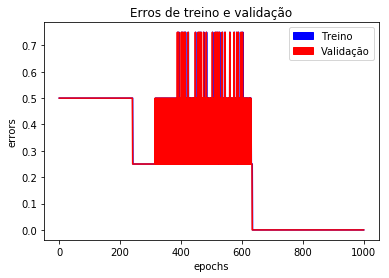

1.0


In [79]:
nn = NeuralNetwork(learning_rate=0.01)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=2, activation=sigmoid))
nn.add_layer(Layer(input_dim=2, output_dim=y.shape[1], activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid, y_valid, epochs=1000, verbose=100)

plot_error([errors_train, errors_valid], ["Treino", "Validação"])

# calculo do erro de predição
y_pred = nn.predict(x_valid)
acc = accuracy_score(y_valid, y_pred)

print(acc)

### Batch

### Arquitetura

- __Parâmentros__: 
 - Learning Rate: 0.05
 - Layers: 2

- __Layer1__:
 - Dimensão de Entrada: 2
 - Dimensão de Saída: 2
 - Função de Ativação: Step

- __Layer2__:
 - Dimensão de Entrada: 2
 - Dimensão de Saída: 1
 - Função de Ativação: Step

- __Treinamento__:
 - Épocas: 800
 - Tamanho do batch: 10

Epoch: 0/1000 
Error: 50.0000%
Epoch: 200/1000 
Error: 75.0000%
Epoch: 400/1000 
Error: 100.0000%
Epoch: 600/1000 
Error: 50.0000%
Epoch: 800/1000 
Error: 75.0000%
Epoch: 1000/1000 
Error: 0.0000%


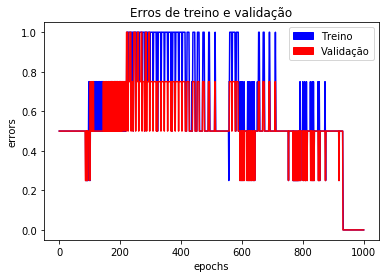

1.0


In [56]:
nn = NeuralNetwork(learning_rate=0.02)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=2, activation=sigmoid))
nn.add_layer(Layer(input_dim=2, output_dim=y.shape[1], activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid, y_valid, batch_size=2 ,epochs=1000, verbose=200)

plot_error([errors_train, errors_valid], ["Treino", "Validação"])

# calculo do erro de predição
y_pred = nn.predict(x_valid)
acc = accuracy_score(y_valid, y_pred)

print(acc)

### Momento

### Arquitetura

- __Parâmentros__: 
 - Learning Rate: 0.01
 - Layers: 2
 - Momentum: 0.9

- __Layer1__:
 - Dimensão de Entrada: 2
 - Dimensão de Saída: 2
 - Função de Ativação: Step

- __Layer2__:
 - Dimensão de Entrada: 2
 - Dimensão de Saída: 1
 - Função de Ativação: Step

- __Treinamento__:
 - Épocas: 300

Epoch: 0/300 
Error: 50.0000%
Epoch: 50/300 
Error: 25.0000%
Epoch: 100/300 
Error: 25.0000%
Epoch: 150/300 
Error: 75.0000%
Epoch: 200/300 
Error: 50.0000%
Epoch: 250/300 
Error: 0.0000%
Epoch: 300/300 
Error: 0.0000%


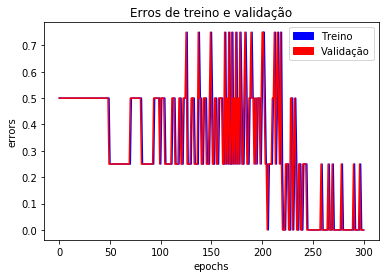

1.0


In [61]:
nn = NeuralNetwork(cost_func=mse, learning_rate=0.01, momentum=0.9)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=2, activation=sigmoid))
nn.add_layer(Layer(input_dim=2, output_dim=y.shape[1], activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid, y_valid, epochs=300, verbose=50)

plot_error([errors_train, errors_valid], ["Treino", "Validação"])

# calculo do erro de predição
y_pred = nn.predict(x_valid)
acc = accuracy_score(y_valid, y_pred)

print(acc)

## 3 b)

X [TREINO]:  (4000, 1)
Y [TREINO]:  (4000, 1)

X [TESTE]:  (800, 1)
Y [TESTE]:  (800, 1)


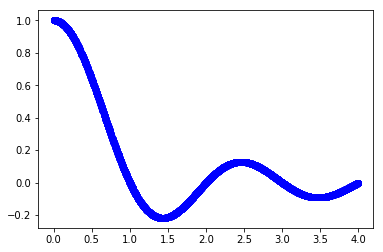

In [141]:
# Leitura dos dados de treinamento e validação

x = []
y = []

# leitura dos dados
for line in open('data/Q3/data_x_3b.txt', 'r').readlines():
    x.append([float(num) for num in line.split(',')])

for line in open('data/Q3/data_y_3b.txt', 'r').readlines():
    y.append([float(num) for num in line.split(',')])

# dados de treino
x = np.array(x[:int(len(x) * 0.8)])
y = np.array(y[:int(len(y) * 0.8)])

# dados de validação
x_valid = np.array(x[int(len(x) * 0.8):])
y_valid = np.array(y[int(len(y) * 0.8):])

print("X [TREINO]: ", x.shape)
print("Y [TREINO]: ", y.shape)
print()
print("X [TESTE]: ", x_valid.shape)
print("Y [TESTE]: ", y_valid.shape)

plt.plot(x, y, 'bo')
plt.show()

### Estocástico

### Arquitetura

- __Parâmentros__: 
 - Learning Rate: 0.05
 - Layers: 3

- __Layer1__:
 - Dimensão de Entrada: 1
 - Dimensão de Saída: 10
 - Função de Ativação: tanh

- __Layer2__:
 - Dimensão de Entrada: 10
 - Dimensão de Saída: 10
 - Função de Ativação: relu

- __Layer3__:
 - Dimensão de Entrada: 10
 - Dimensão de Saída: 1
 - Função de Ativação: tanh

- __Treinamento__:
 - Épocas: 500

Epoch: 0/500 
Error: 15.6921%
Epoch: 50/500 
Error: 0.7502%
Epoch: 100/500 
Error: 0.6900%
Epoch: 150/500 
Error: 0.6687%
Epoch: 200/500 
Error: 0.6547%
Epoch: 250/500 
Error: 0.6435%
Epoch: 300/500 
Error: 0.6347%
Epoch: 350/500 
Error: 0.6268%
Epoch: 400/500 
Error: 0.6226%
Epoch: 450/500 
Error: 0.6167%
Epoch: 500/500 
Error: 0.6116%


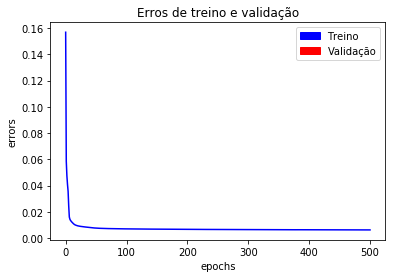

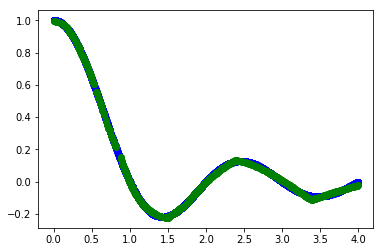

In [144]:
nn = NeuralNetwork(learning_rate=0.05)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=10, activation=tanh))
nn.add_layer(Layer(input_dim=10, output_dim=10, activation=relu))
nn.add_layer(Layer(input_dim=10, output_dim=y.shape[1], activation=tanh))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid, y_valid, batch_size=1, epochs=500, verbose=50, accuracy=False)

plot_error([errors_train, errors_valid], ["Treino", "Validação"])

# calculo do erro de predição
y_pred = nn.predict(x_valid)

plt.plot(x, y, 'bo')
plt.plot(x_valid, y_pred, 'go')
plt.show()

## Batch

### Arquitetura

- __Parâmentros__: 
 - Learning Rate: 0.001
 - Layers: 4

- __Layer1__:
 - Dimensão de Entrada: 1
 - Dimensão de Saída: 4
 - Função de Ativação: tanh

- __Layer2__:
 - Dimensão de Entrada: 4
 - Dimensão de Saída: 4
 - Função de Ativação: relu

- __Layer3__:
 - Dimensão de Entrada: 4
 - Dimensão de Saída: 4
 - Função de Ativação: relu

- __Layer4__:
 - Dimensão de Entrada: 4
 - Dimensão de Saída: 1
 - Função de Ativação: tanh

- __Treinamento__:
 - Épocas: 1000
 - Tamanho do Batch: 30

Epoch: 0/1000 
Error: 23.5521%
Epoch: 100/1000 
Error: 3.9650%
Epoch: 200/1000 
Error: 3.5293%
Epoch: 300/1000 
Error: 3.2818%
Epoch: 400/1000 
Error: 3.0122%
Epoch: 500/1000 
Error: 2.7763%
Epoch: 600/1000 
Error: 2.5968%
Epoch: 700/1000 
Error: 2.4821%
Epoch: 800/1000 
Error: 2.4160%
Epoch: 900/1000 
Error: 2.3826%
Epoch: 1000/1000 
Error: 2.3643%


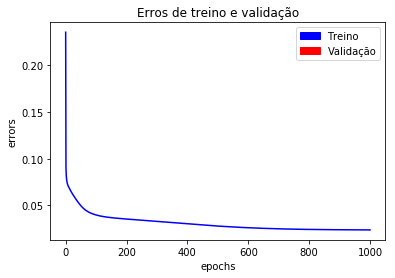

0.0


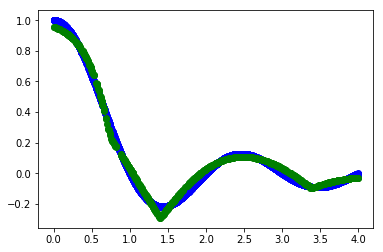

In [133]:
nn = NeuralNetwork(learning_rate=0.001)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=4, activation=tanh))
nn.add_layer(Layer(input_dim=4, output_dim=4, activation=relu))
nn.add_layer(Layer(input_dim=4, output_dim=4, activation=relu))
nn.add_layer(Layer(input_dim=4, output_dim=y.shape[1], activation=tanh))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid, y_valid, batch_size=30, epochs=1000, verbose=100, accuracy=False)

plot_error([errors_train, errors_valid], ["Treino", "Validação"])

# calculo do erro de predição
y_pred = nn.predict(x_valid)

plt.plot(x, y, 'bo')
plt.plot(x_valid, y_pred, 'go')
plt.show()

## Momentum

### Arquitetura

- __Parâmentros__: 
 - Learning Rate: 0.001
 - Layers: 3
 - Momentum: 0.9

- __Layer1__:
 - Dimensão de Entrada: 1
 - Dimensão de Saída: 20
 - Função de Ativação: tanh

- __Layer2__:
 - Dimensão de Entrada: 20
 - Dimensão de Saída: 20
 - Função de Ativação: relu

- __Layer3__:
 - Dimensão de Entrada: 20
 - Dimensão de Saída: 1
 - Função de Ativação: tanh

- __Treinamento__:
 - Épocas: 1000

Epoch: 0/100 
Error: 13.3902%
Epoch: 20/100 
Error: 1.4868%
Epoch: 40/100 
Error: 1.2532%
Epoch: 60/100 
Error: 1.2072%
Epoch: 80/100 
Error: 1.1501%
Epoch: 100/100 
Error: 1.0950%


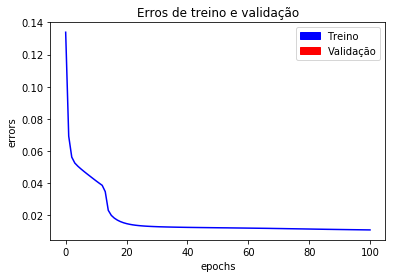

0.0


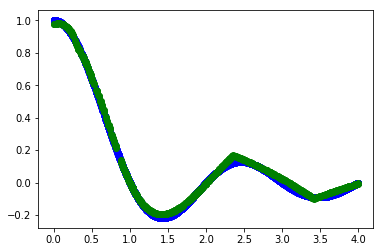

In [56]:
nn = NeuralNetwork(cost_func=mse, learning_rate=0.001, momentum=0.9)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=20, activation=tanh))
nn.add_layer(Layer(input_dim=20, output_dim=20, activation=relu))
nn.add_layer(Layer(input_dim=20, output_dim=y.shape[1], activation=tanh))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid, y_valid, batch_size=1, epochs=100, verbose=20, accuracy=False)

plot_error([errors_train, errors_valid], ["Treino", "Validação"])

# calculo do erro de predição
y_pred = nn.predict(x_valid)

plt.plot(x, y, 'bo')
plt.plot(x_valid, y_pred, 'go')
plt.show()

# Questão 4 - Classificação do Circulo

## Problema

Considere um problema de classificação de padrões constituído de oito padrões. A distribuição dos padrões forma um círculo centrado na origem de raio unitário e contido no círculo um losango também centrado na origem e com lados iguais a raiz de 2. Os dados das classe C1, C2, C3, C4 corresponde aos quatro setores do losango e as outras quatro classes correspondem aos setores delimitados pelo círculo e os lados do losango. Após gerar aleatoriamente dados que venham formar estas distribuições de dados, selecione um conjunto de treinamento e um conjunto de validação. Treine uma rede perceptron para classificar os padrões associados a cada uma das classes. Verifique o desempenho do classificador usando o conjunto de validação e calculando a matriz de confusão.

## Leitura dos dados

X [TREINO]:  (6295, 2)
Y [TREINO]:  (6295, 1)

X [TESTE]:  (1259, 2)
Y [TESTE]:  (1259, 1)


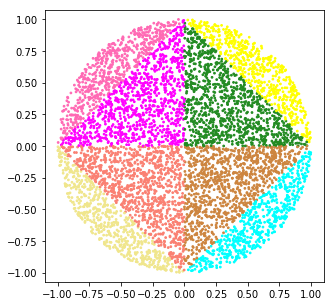

In [14]:
# Leitura dos dados de treinamento e validação

x = []
y = []

# leitura dos dados
for line in open('data/Q4/data_x_4.txt', 'r').readlines():
    x.append([float(num) for num in line.split(',')])

for line in open('data/Q4/data_y_4.txt', 'r').readlines():
    y.append([float(num) for num in line.split(',')])

# dados de treino
x = np.array(x[:int(len(x) * 0.8)])
y = np.array(y[:int(len(y) * 0.8)])

# dados de validação
x_valid = np.array(x[int(len(x) * 0.8):])
y_valid = np.array(y[int(len(y) * 0.8):])

print("X [TREINO]: ", x.shape)
print("Y [TREINO]: ", y.shape)
print()
print("X [TESTE]: ", x_valid.shape)
print("Y [TESTE]: ", y_valid.shape)

colors = {0:'salmon', 1:'peru', 2:'magenta', 3:'forestgreen', 4:'khaki', 5:'aqua', 6:'hotpink', 7:'yellow'}

plt.figure(figsize=(5,5))
plt.scatter(x[:,0], x[:,1], s = 3, c=[colors[int(yp[0])] for yp in y])
plt.axis('equal')
plt.show()

onehot = OneHotEncoder(sparse=False)
y_oh = onehot.fit_transform(y)

## Modelo

### Arquitetura

- __Parâmentros__: 
 - Learning Rate: 0.01
 - Layers: 2
 - Momentum: 0.9

- __Layer1__:
 - Dimensão de Entrada: 2
 - Dimensão de Saída: 20
 - Função de Ativação: linear

- __Layer2__:
 - Dimensão de Entrada: 20
 - Dimensão de Saída: 8
 - Função de Ativação: linear

- __Treinamento__:
 - Épocas: 10000

Epoch: 0/10000 
Error: 276.0445%
Epoch: 500/10000 
Error: 5.9253%
Epoch: 1000/10000 
Error: 3.7490%
Epoch: 1500/10000 
Error: 2.9230%
Epoch: 2000/10000 
Error: 2.7482%
Epoch: 2500/10000 
Error: 2.4146%
Epoch: 3000/10000 
Error: 2.3193%
Epoch: 3500/10000 
Error: 2.1763%
Epoch: 4000/10000 
Error: 2.2240%
Epoch: 4500/10000 
Error: 1.9063%
Epoch: 5000/10000 
Error: 1.8268%
Epoch: 5500/10000 
Error: 1.7633%
Epoch: 6000/10000 
Error: 1.6998%
Epoch: 6500/10000 
Error: 1.6362%
Epoch: 7000/10000 
Error: 1.6362%
Epoch: 7500/10000 
Error: 1.6362%
Epoch: 8000/10000 
Error: 1.6998%
Epoch: 8500/10000 
Error: 1.6680%
Epoch: 9000/10000 
Error: 1.6680%
Epoch: 9500/10000 
Error: 1.6680%
Epoch: 10000/10000 
Error: 1.6203%


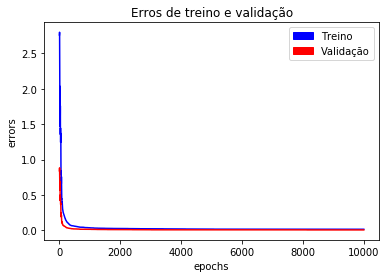

Matriz de confusão: 

    1   2   3   4   5   6   7   8
1 [200   1   0   0   1   0   0   0]
2 [  0 162   0   0   0   0   0   0]
3 [  2   0 199   0   0   0   0   0]
4 [  0   3   2 199   0   0   0   0]
5 [  0   0   0   0 130   0   0   0]
6 [  0   0   0   0   0 105   0   0]
7 [  0   0   0   0   0   0 124   0]
8 [  0   0   0   0   0   0   0 131]


In [29]:
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01, momentum=0.9)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=20, activation=linear))
nn.add_layer(Layer(input_dim=20, output_dim=y_oh.shape[1], activation=linear))

# treinamento
errors_train, errors_valid = nn.fit(x, y_oh, x_valid, y_valid, epochs=10000, verbose=500, one_hot=True)

plot_error([errors_train, errors_valid], ["Treino", "Validação"])

# prediction
y_pred = nn.predict(x_valid).argmax(axis=1)
accuracy_score(y_valid, y_pred)

print("Matriz de confusão: \n")

confMatrix = confusion_matrix(y_valid, y_pred)

print('   ', '   '.join([str(i+1) for i in range(len(confMatrix))]))

for index, confusion in enumerate(confMatrix):
    print(index + 1, confusion)


# Questão 5

## Modelo

### Arquitetura

- Parâmetros:
    - Taxa de aprendizagem: 0.01
    - Camadas: 2
- Camada 1:
    - Dimensão de Entrada: k passos
    - Dimensão de Saída: 20
    - Função de Ativação: tanh
- Layer2:
    - Dimensão de Entrada: n predições
    - Dimensão de Saída: 20
    - Função de Ativação: tanh
- Treinamento:
    - Épocas: 15000

Epoch: 0/150 
Error: 88.3511%


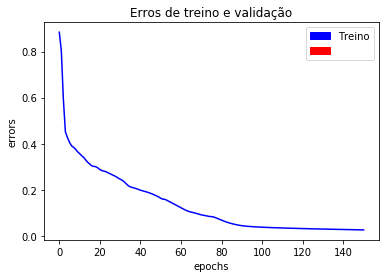

TypeError: 'float' object is not subscriptable

In [144]:
k = 10
n = 3

x = np.arange(-k, 100 + n)
y = np.sin(x + np.sin(x)**2)

x = x.tolist()
y = y.tolist()

x_train = []
y_train = []

for index in range(k, len(x) - n):
    x_train.append(y[index - k : index])
    y_train.append(y[index + 1 : index + 1 + n])

x = x[k: -n]
x_train = np.array(x_train)
y_train = np.array(y_train)

# Instanciando o modelo
# nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01, momentum=0.2)
nn = NeuralNetwork(cost_func=mse, learning_rate=0.01, momentum=0.9)
nn.add_layer(Layer(input_dim=x_train.shape[1], output_dim=20, activation=tanh))
nn.add_layer(Layer(input_dim=20, output_dim=y_train.shape[1], activation=tanh))

# Treinando a rede
error_train, _ = nn.fit(x_train, y_train, batch_size=20, epochs=150, verbose=1000, accuracy=False)

#print(x_train)
#print(y_train)

plot_error([error_train, []], ["Treino", ""])

y_pred = nn.predict(x_train)
plot_q5(x, y, y_pred)
